# feature engineering encoding and modeling 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, f1_score, roc_auc_score, average_precision_score,
    precision_recall_curve, make_scorer
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("DATA/cleaned_churn.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [4]:
df_vc = {}

for col in df.columns:
    df_vc[col] = df[col].value_counts()

for col , count in df_vc.items():
    print(count)

gender
Male      3555
Female    3488
Name: count, dtype: int64
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
Partner
No     3641
Yes    3402
Name: count, dtype: int64
Dependents
No     4933
Yes    2110
Name: count, dtype: int64
tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64
PhoneService
Yes    6361
No      682
Name: count, dtype: int64
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64
DeviceProtection
No                     3095
Yes                    2422
No

In [5]:
cols_with_no_service = [
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

for col in cols_with_no_service:
    df[col] = df[col].replace({
        'No internet service': 'No',
        'No phone service': 'No'
    })


In [6]:
df['is_auto_payment'] = df['PaymentMethod'].apply(lambda x: 1 if 'automatic' in x.lower() else 0)
df['tenure_per_monthly'] = df['tenure'] / (df['MonthlyCharges'] + 1e-6)
df['avg_monthly_from_total'] = df['TotalCharges'] / (df['tenure'] + 1e-6)
df['has_streaming'] = ((df['StreamingTV'] == 'Yes') | (df['StreamingMovies'] == 'Yes')).astype(int)
df['has_support_services'] = ((df['OnlineSecurity'] == 'Yes') | (df['OnlineBackup'] == 'Yes') | (df['DeviceProtection'] == 'Yes') | (df['TechSupport'] == 'Yes')).astype(int)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  7043 non-null   object 
 1   SeniorCitizen           7043 non-null   int64  
 2   Partner                 7043 non-null   object 
 3   Dependents              7043 non-null   object 
 4   tenure                  7043 non-null   int64  
 5   PhoneService            7043 non-null   object 
 6   MultipleLines           7043 non-null   object 
 7   InternetService         7043 non-null   object 
 8   OnlineSecurity          7043 non-null   object 
 9   OnlineBackup            7043 non-null   object 
 10  DeviceProtection        7043 non-null   object 
 11  TechSupport             7043 non-null   object 
 12  StreamingTV             7043 non-null   object 
 13  StreamingMovies         7043 non-null   object 
 14  Contract                7043 non-null   

# ENCODING

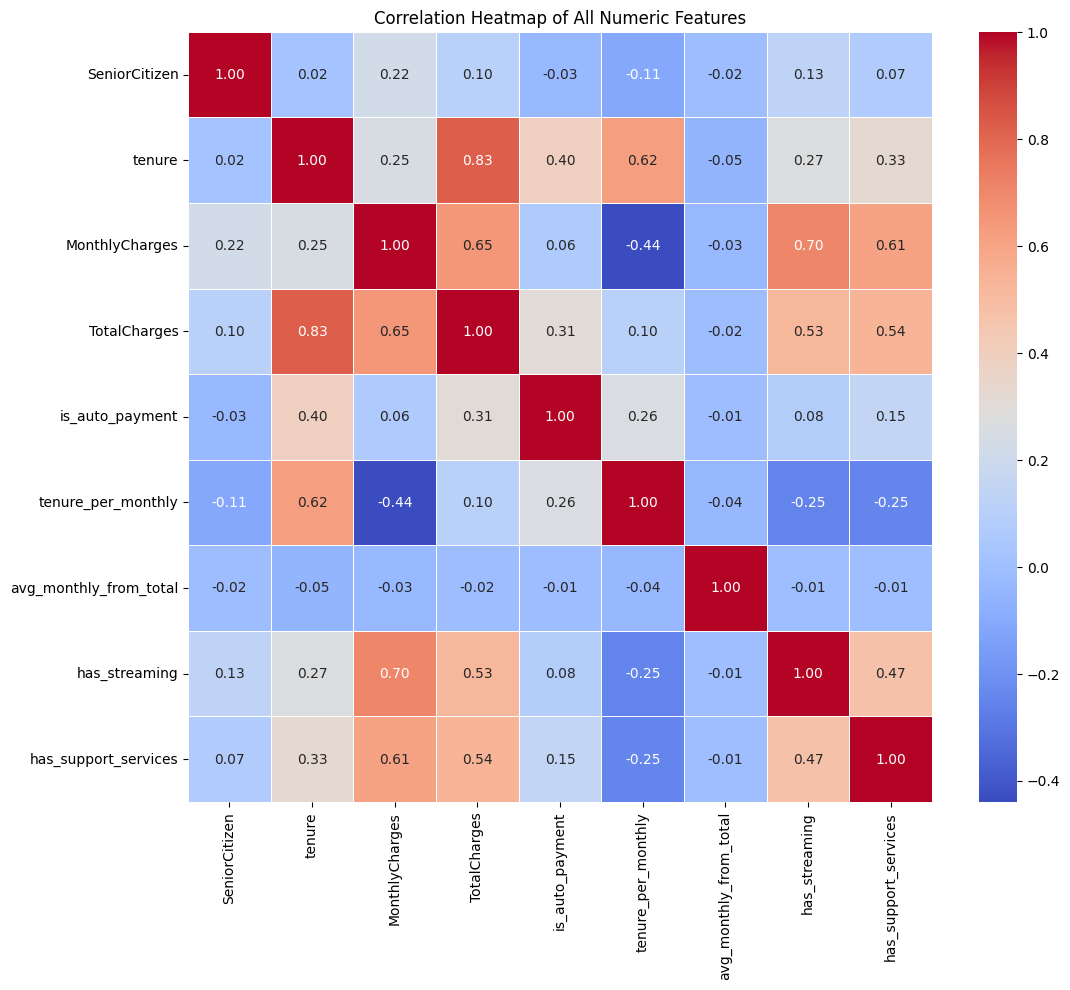

In [8]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))  # Optional: adjust size for readability
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of All Numeric Features")
plt.show()


In [9]:
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

print("Target variable 'Churn' encoded to 1/0.")

Target variable 'Churn' encoded to 1/0.


In [10]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5634, 24)
X_test shape: (1409, 24)
y_train shape: (5634,)
y_test shape: (1409,)


In [11]:
X_train.to_csv("DATA/X_train.csv", index=False)
X_test.to_csv("DATA/X_test.csv", index=False)
y_train.to_csv("DATA/y_train.csv", index=False)
y_test.to_csv("DATA/y_test.csv", index=False)

In [12]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Logestic Regression (Baseline)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# pipeline
lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

lr_pipe.fit(X_train, y_train)

y_prob_lr = lr_pipe.predict_proba(X_test)[:, 1]
y_pred_lr = (y_prob_lr >= 0.5).astype(int)

# Evaluate
print("===== Logistic Regression Test Results =====")
print(classification_report(y_test, y_pred_lr))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")
print(f"PR AUC:  {average_precision_score(y_test, y_prob_lr):.4f}")

===== Logistic Regression Test Results =====
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.75      0.76      1409

ROC AUC: 0.8416
PR AUC:  0.6278


# Random Forest Classifier (Baseline)

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)

y_prob_rf = rf_pipe.predict_proba(X_test)[:, 1]
y_pred_rf = (y_prob_rf >= 0.5).astype(int)

# Evaluate
print("===== Random Forest Test Results =====")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")
print(f"PR AUC:  {average_precision_score(y_test, y_prob_rf):.4f}")

===== Random Forest Test Results =====
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1035
           1       0.61      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.78      0.77      1409

ROC AUC: 0.8235
PR AUC:  0.6193


# XGB + SMOTE

In [18]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

xgb_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    ))
])

# Hyperparameter grid
param_dist = {
    'clf__n_estimators': [200, 300, 400],
    'clf__max_depth': [3, 4, 5, 6],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.7, 0.9, 1.0],
    'clf__gamma': [0, 0.1, 0.3]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)

rs_xgb = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring=f1_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rs_xgb.fit(X_train, y_train)
print("\nBest Params:", rs_xgb.best_params_)
print(f"Best CV F1: {rs_xgb.best_score_:.4f}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best Params: {'clf__subsample': 0.8, 'clf__n_estimators': 200, 'clf__max_depth': 4, 'clf__learning_rate': 0.01, 'clf__gamma': 0.3, 'clf__colsample_bytree': 0.7}
Best CV F1: 0.6378


In [19]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

best_model = rs_xgb.best_estimator_

best_model.fit(X_train, y_train)

y_prob_xgb = best_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

# Evaluate
print("===== XGBoost Test Results =====")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print(f"PR AUC:  {average_precision_score(y_test, y_prob_xgb):.4f}")

===== XGBoost Test Results =====
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.76      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.77      1409

ROC AUC: 0.8408
PR AUC:  0.6265


# compairing 

In [20]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score

results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'F1': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    'ROC_AUC': [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb)
    ],
    'PR_AUC': [
        average_precision_score(y_test, y_prob_lr),
        average_precision_score(y_test, y_prob_rf),
        average_precision_score(y_test, y_prob_xgb)
    ]
}

summary_df = pd.DataFrame(results).sort_values(by='F1', ascending=False).reset_index(drop=True)

print("===== Model Performance Comparison =====")
display(summary_df)


===== Model Performance Comparison =====


,Model,F1,Precision,Recall,ROC_AUC,PR_AUC
0,XGBoost,0.622271,0.525830,0.762032,0.840762,0.626522
1,Logistic Regression,0.618491,0.513228,0.778075,0.841582,0.627768
2,Random Forest,0.526475,0.606272,0.465241,0.823527,0.619325


# PIPELINE

In [22]:
# === Cell A: Feature Engineering + Preprocessor ===
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# 1️⃣ Feature Engineering Function
def feature_engineering_fn(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Defensive handling for missing columns
    for col in ['PaymentMethod','StreamingTV','StreamingMovies','OnlineSecurity',
                'OnlineBackup','DeviceProtection','TechSupport','MonthlyCharges','TotalCharges','tenure']:
        if col not in df.columns:
            df[col] = np.nan

    df['is_auto_payment'] = df['PaymentMethod'].apply(
        lambda x: 1 if isinstance(x,str) and 'automatic' in x.lower() else 0)
    df['tenure_per_monthly'] = df['tenure'] / (df['MonthlyCharges'].replace(0, np.nan) + 1e-6)
    df['avg_monthly_from_total'] = df['TotalCharges'] / (df['tenure'].replace(0, np.nan) + 1e-6)
    df['has_streaming'] = ((df['StreamingTV'] == 'Yes') | (df['StreamingMovies'] == 'Yes')).astype(int)
    df['has_support_services'] = (
        (df['OnlineSecurity'] == 'Yes') | (df['OnlineBackup'] == 'Yes') |
        (df['DeviceProtection'] == 'Yes') | (df['TechSupport'] == 'Yes')
    ).astype(int)
    return df

# Transformer wrapper for pipeline integration
feat_eng = FunctionTransformer(feature_engineering_fn, validate=False)

# 2️⃣ Preprocessing setup
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Add engineered columns to numeric list if they exist after transformation
engineered_cols = ['is_auto_payment','tenure_per_monthly','avg_monthly_from_total',
                   'has_streaming','has_support_services']
for c in engineered_cols:
    if c not in num_cols:
        num_cols.append(c)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cat_cols),
    ('num', numeric_transformer, num_cols)
], remainder='drop')

print(f"Feature engineering + preprocessing ready. Cat: {len(cat_cols)} Num: {len(num_cols)}")

Feature engineering + preprocessing ready. Cat: 15 Num: 9


In [25]:
# === Cell B: Model Pipelines (Feature Engg + Preprocessor + SMOTE + Model) ===
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

smote = SMOTE(random_state=42)

lr_pipeline = ImbPipeline(steps=[
    ('feature_engineering', feat_eng),
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

rf_pipeline = ImbPipeline(steps=[
    ('feature_engineering', feat_eng),
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('model', RandomForestClassifier(n_estimators=300, class_weight='balanced',
                                     n_jobs=-1, random_state=42))
])


xgb_pipeline = ImbPipeline(steps=[
    ('feature_engineering', feat_eng),
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('model', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        learning_rate=0.01,    
        n_estimators=200,       
        max_depth=4,           
        gamma=0.3,             
        subsample=0.8,         
        colsample_bytree=0.7   
    ))
])

print("Pipelines built: lr_pipeline, rf_pipeline, xgb_pipeline")

# Choose which one to train
chosen_pipeline_name = 'xgb'  # change to 'lr' or 'rf' if needed
chosen_pipeline = {'lr': lr_pipeline, 'rf': rf_pipeline, 'xgb': xgb_pipeline}[chosen_pipeline_name]

chosen_pipeline.fit(X_train, y_train)
print(f"Fitted pipeline: {chosen_pipeline_name}")


Pipelines built: lr_pipeline, rf_pipeline, xgb_pipeline
Fitted pipeline: xgb


In [26]:
# === Cell C: Save final pipeline and sanity check ===
import joblib
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, f1_score

# Save
joblib.dump(chosen_pipeline, f"final_churn_{chosen_pipeline_name}_pipeline.pkl")
print(f"Saved final pipeline to final_churn_{chosen_pipeline_name}_pipeline.pkl")

# Evaluate
y_pred = chosen_pipeline.predict(X_test)
y_prob = chosen_pipeline.predict_proba(X_test)[:, 1]

print("\n===== Sanity Check Evaluation on Test Set =====")
print(classification_report(y_test, y_pred))
print(f"F1: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(f"PR AUC: {average_precision_score(y_test, y_prob):.4f}")


Saved final pipeline to final_churn_xgb_pipeline.pkl

===== Sanity Check Evaluation on Test Set =====
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.52      0.76      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.77      1409

F1: 0.6208
ROC AUC: 0.8410
PR AUC: 0.6266
